In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [28]:
# Chemin de sauvegarde
save_dir = "/content/drive/My Drive/projet_7/"

In [30]:
# Évaluation et affichage des courbes
def afficher_courbes_apprentissage(history):
    """
    Affiche les courbes de loss et d'accuracy pour l'entraînement et la validation.
    """
    epochs = range(1, len(history.history['loss']) + 1)

    # Récupérer les métriques finales
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    # Créer le graphique
    plt.figure(figsize=(12, 5))

    # Courbes de loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label=f'Train Loss (Final: {final_train_loss:.4f})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Final: {final_val_loss:.4f})')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve - Loss")
    plt.legend()

    # Ajouter les valeurs finales sur le graphique de loss
    plt.text(len(history.history['loss']) - 1, final_train_loss, f"{final_train_loss:.4f}", color='blue', ha='left')
    plt.text(len(history.history['val_loss']) - 1, final_val_loss, f"{final_val_loss:.4f}", color='orange', ha='left')

    # Courbes d'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label=f'Train Accuracy (Final: {final_train_accuracy:.4f})')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy (Final: {final_val_accuracy:.4f})')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve - Accuracy")
    plt.legend()

    # Ajouter les valeurs finales sur le graphique d'accuracy
    plt.text(len(history.history['accuracy']) - 1, final_train_accuracy, f"{final_train_accuracy:.4f}", color='blue', ha='left')
    plt.text(len(history.history['val_accuracy']) - 1, final_val_accuracy, f"{final_val_accuracy:.4f}", color='orange', ha='left')

    plt.tight_layout()
    courbe_apprentissage_path = f"{save_dir}courbes_apprentissage.png"
    plt.savefig(courbe_apprentissage_path)
    print(f"Courbes d'apprentissage sauvegardées dans : {courbe_apprentissage_path}")
    plt.show()

In [26]:
def afficher_courbe_auc_roc(model, X_test, y_test):
    """
    Affiche la courbe ROC et calcule l'AUC.
    """
    # Prédictions sur l'ensemble de test
    y_pred_proba = model.predict(X_test).ravel()

    # Calculer les métriques de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')

    courbe_roc_path = f"{save_dir}courbe_roc.png"
    plt.savefig(courbe_roc_path)
    print(f"Courbe ROC sauvegardée dans : {courbe_roc_path}")
    plt.show()

##### Chargement des données

In [9]:
# Montée de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Charger les données nettoyées
df = pd.read_csv('/content/drive/My Drive/projet_7/df_modele_final_vf.csv', encoding='utf-8')

# Vérification des données
print("Aperçu des données :")
print(df.head())

print("\nInformations sur le DataFrame :")
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Aperçu des données :
   sentiment          id                          date           user  \
0          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  scotthamilton   
1          0  1467810917  Mon Apr 06 22:19:53 PDT 2009       mattycus   
2          0  1467811184  Mon Apr 06 22:19:57 PDT 2009        ElleCTF   
3          0  1467811193  Mon Apr 06 22:19:57 PDT 2009         Karoli   
4          0  1467811372  Mon Apr 06 22:20:00 PDT 2009       joy_wolf   

                                                text  \
0  is upset that he can't update his Facebook by ...   
1  @Kenichan I dived many times for the ball. Man...   
2    my whole body feels itchy and like its on fire    
3  @nationwideclass no, it's not behaving at all....   
4                      @Kwesidei not the whole crew    

                                        text_cleaned  text_length  \
0  up

##### Préparation des données

###### Séparation des textes et labels

In [10]:
# Utiliser la colonne stemmatisée ou lemmatisée
texts = df['text_stemmed'].tolist()  # Ou df['text_lemmatized']
labels = df['sentiment'].tolist()

# Vérifier le nombre de tweets et de labels
print(f"Nombre de textes : {len(texts)}")
print(f"Nombre de labels : {len(labels)}")

Nombre de textes : 1573595
Nombre de labels : 1573595


###### Division des données en ensembles d'entraînement, validation et test

In [11]:
# Diviser les données en train/val/test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Vérification des tailles des ensembles
print(f"Nombre de tweets dans l'ensemble d'entraînement : {len(train_texts)}")
print(f"Nombre de tweets dans l'ensemble de validation : {len(val_texts)}")
print(f"Nombre de tweets dans l'ensemble de test : {len(test_texts)}")

Nombre de tweets dans l'ensemble d'entraînement : 1101516
Nombre de tweets dans l'ensemble de validation : 236039
Nombre de tweets dans l'ensemble de test : 236040


###### Analyse de la distribution des labels

In [12]:
def afficher_distribution(labels, nom_ensemble):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nDistribution des labels dans l'ensemble {nom_ensemble} :")
    for label, count in zip(unique, counts):
        print(f"Label {label} : {count} ({count / len(labels) * 100:.2f}%)")

afficher_distribution(train_labels, "d'entraînement")
afficher_distribution(val_labels, "de validation")
afficher_distribution(test_labels, "de test")


Distribution des labels dans l'ensemble d'entraînement :
Label 0 : 550356 (49.96%)
Label 1 : 551160 (50.04%)

Distribution des labels dans l'ensemble de validation :
Label 0 : 117933 (49.96%)
Label 1 : 118106 (50.04%)

Distribution des labels dans l'ensemble de test :
Label 0 : 117934 (49.96%)
Label 1 : 118106 (50.04%)


##### Création et Entraînement de l'Embedding Word2Vec

In [13]:
# Préparer les phrases pour Word2Vec
train_sentences = [text.split() for text in train_texts]

# Entraîner Word2Vec sur les tweets d'entraînement
word2vec_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,  # Taille des vecteurs
    window=5,         # Taille de la fenêtre contextuelle
    min_count=5,      # Ignorer les mots avec une fréquence inférieure
    workers=4         # Nombre de threads pour l'entraînement
)

# Sauvegarder le modèle pour un usage ultérieur
word2vec_model.save("word2vec_model_tweets.model")

print("Modèle Word2Vec entraîné et sauvegardé.")

Modèle Word2Vec entraîné et sauvegardé.


In [14]:
# Fonction pour calculer les embeddings moyens
def get_avg_word2vec_embeddings(texts, model, vector_size):
    embeddings = []
    for text in texts:
        word_vectors = [model.wv[word] for word in text.split() if word in model.wv]
        if word_vectors:
            avg_vector = np.mean(word_vectors, axis=0)
        else:
            avg_vector = np.zeros(vector_size)  # Vecteur nul pour les tweets vides
        embeddings.append(avg_vector)
    return np.array(embeddings)

# Calculer les embeddings pour chaque ensemble
train_embeddings = get_avg_word2vec_embeddings(train_texts, word2vec_model, 100)
val_embeddings = get_avg_word2vec_embeddings(val_texts, word2vec_model, 100)
test_embeddings = get_avg_word2vec_embeddings(test_texts, word2vec_model, 100)

print("Embeddings calculés pour les ensembles d'entraînement, de validation et de test.")

Embeddings calculés pour les ensembles d'entraînement, de validation et de test.


In [16]:
# Sauvegarder les embeddings
np.save("/content/drive/My Drive/projet_7/train_embeddings.npy", train_embeddings)
np.save("/content/drive/My Drive/projet_7/val_embeddings.npy", val_embeddings)
np.save("/content/drive/My Drive/projet_7/test_embeddings.npy", test_embeddings)

print("Embeddings sauvegardés pour un usage ultérieur.")

Embeddings sauvegardés pour un usage ultérieur.


##### Construire le modèle LSTM Bidirectionnel

In [17]:
def build_lstm_model(input_shape, bidirectional=True):
    """
    Construit et compile un modèle LSTM avec une option bidirectionnelle.

    Args:
        input_shape (tuple): Shape des données d'entrée pour le modèle (timesteps, features).
        bidirectional (bool): Si True, utilise un LSTM bidirectionnel.

    Returns:
        Sequential: Modèle LSTM compilé.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))  # Utilisation de input_shape directement

    if bidirectional:
        model.add(Bidirectional(LSTM(64, return_sequences=False)))
    else:
        model.add(LSTM(64, return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Pour la classification binaire
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
if len(train_embeddings.shape) == 2:
    train_embeddings = train_embeddings[:, np.newaxis, :]
    val_embeddings = val_embeddings[:, np.newaxis, :]
    test_embeddings = test_embeddings[:, np.newaxis, :]
    print(f"Nouvelle shape des embeddings d'entraînement : {train_embeddings.shape}")

Nouvelle shape des embeddings d'entraînement : (1101516, 1, 100)


##### Entraîner le modèle

In [21]:
# Initialiser le modèle
input_shape = (train_embeddings.shape[1], train_embeddings.shape[2])  # (timesteps, features)
lstm_model = build_lstm_model(input_shape, bidirectional=True)

# Early stopping pour arrêter si la validation ne s'améliore plus
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = lstm_model.fit(
    train_embeddings, np.array(train_labels),
    validation_data=(val_embeddings, np.array(val_labels)),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

print("Entraînement terminé.")

Epoch 1/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.7462 - loss: 0.5129 - val_accuracy: 0.7588 - val_loss: 0.4913
Epoch 2/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 146s 8ms/step - accuracy: 0.7580 - loss: 0.4946 - val_accuracy: 0.7631 - val_loss: 0.4860
Epoch 3/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 135s 7ms/step - accuracy: 0.7619 - loss: 0.4890 - val_accuracy: 0.7639 - val_loss: 0.4834
Epoch 4/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.7626 - loss: 0.4875 - val_accuracy: 0.7649 - val_loss: 0.4816
Epoch 5/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 153s 8ms/step - accuracy: 0.7638 - loss: 0.4853 - val_accuracy: 0.7656 - val_loss: 0.4808
Epoch 6/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 132s 8ms/step - accuracy: 0.7653 - loss: 0.4832 - val_accuracy: 0.7663 - val_loss: 0.4797
Epoch 7/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - accuracy: 0.7661 - loss: 0.4828 - val_accuracy: 0.7669 - val_loss: 0.4791
Epoch 8/20
17212/17212 ━━━━━━━━━━━━━━━━━━━━ 125s 7ms/step - ac

##### Evaluation du modèle

7377/7377 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
Accuracy: 0.77
Precision: 0.77
Recall: 0.78
F1 Score: 0.77
AUC: 0.85


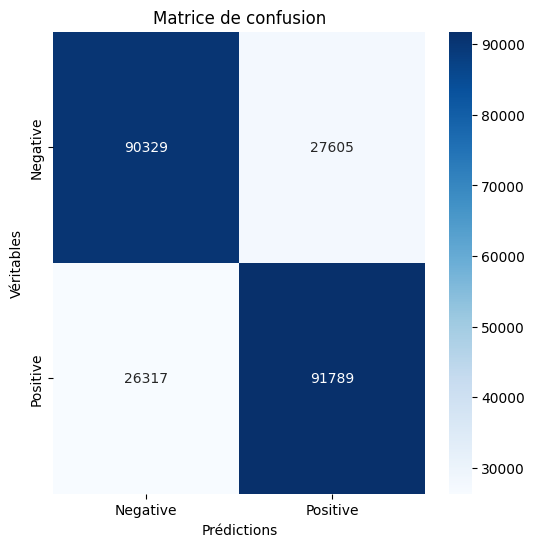

Courbes d'apprentissage sauvegardées dans : /content/drive/My Drive/projet_7/courbes_apprentissage.png


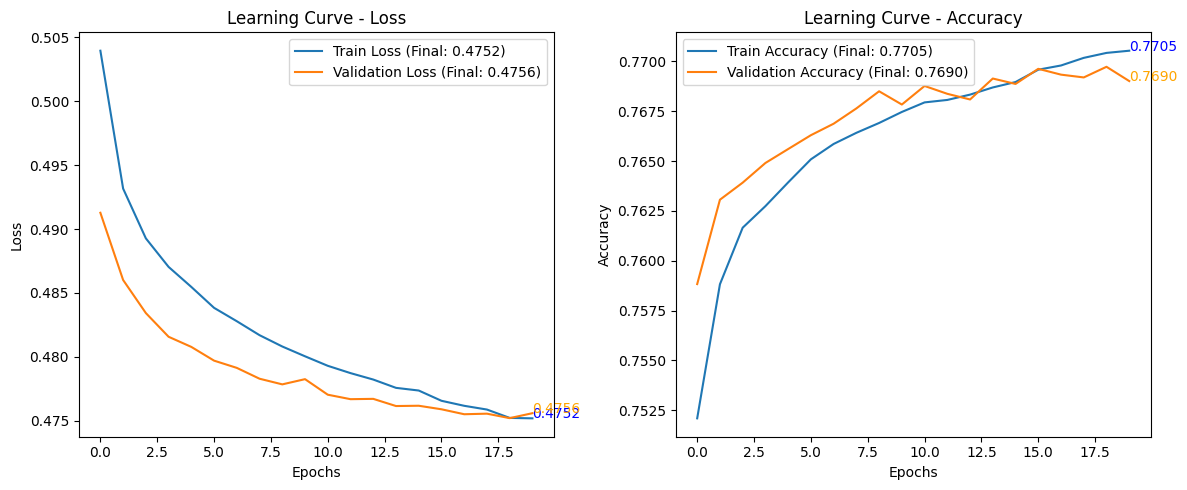

7377/7377 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Courbe ROC sauvegardée dans : /content/drive/My Drive/projet_7/courbe_roc.png


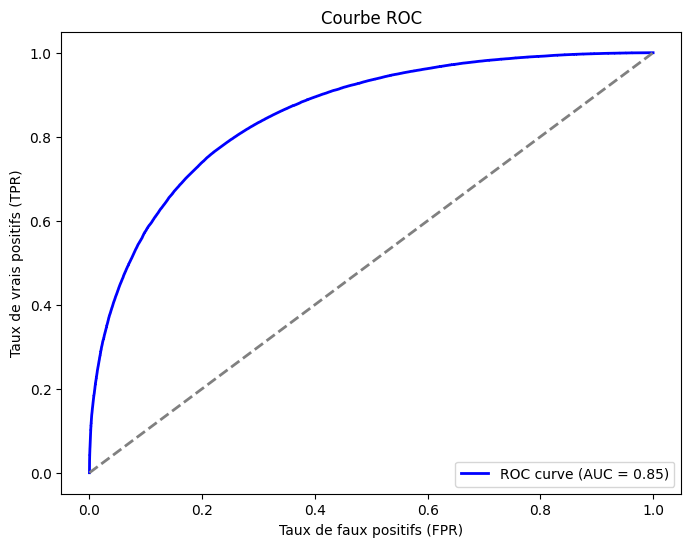

In [31]:
# Prédictions sur l'ensemble de test
y_pred_proba = lstm_model.predict(test_embeddings)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calcul des métriques
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
auc = roc_auc_score(test_labels, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

# Matrice de confusion
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()

# Afficher les courbes
afficher_courbes_apprentissage(history)
afficher_courbe_auc_roc(lstm_model, test_embeddings, test_labels)

##### Sauvegarde du modèle TensorFlow et conversion TensorFlow Lite

In [52]:
# Répertoire de sauvegarde
save_dir_mod = "/content/drive/My Drive/projet_7/saved_models/"
os.makedirs(save_dir_mod, exist_ok=True)

# Sauvegarde du modèle Keras au format .h5
model_path_h5 = '/content/drive/My Drive/projet_7/lstm_bidirectional_model.h5'
lstm_model.save(model_path_h5)
print(f"Modèle Keras sauvegardé sous : {model_path_h5}")

# Conversion du modèle Keras en TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Opérations par défaut de TFLite
    tf.lite.OpsSet.SELECT_TF_OPS    # Inclure les opérations TensorFlow
]
converter._experimental_lower_tensor_list_ops = False

# Conversion
try:
    tflite_model = converter.convert()

    # Sauvegarde du modèle TensorFlow Lite au format .tflite
    with open("lstm_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("Modèle converti et sauvegardé sous le nom lstm_model.tflite")

except Exception as e:
    print(f"Erreur lors de la conversion en TFLite : {e}")

Modèle Keras sauvegardé sous : /content/drive/My Drive/projet_7/lstm_bidirectional_model.h5
Saved artifact at '/tmp/tmpx_a5hlxt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 100), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134870473051120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134871043061392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134869898271328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134870474328368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134869898269040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134870474328016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134870473056048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134871045266368: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modèle converti et sauvegardé sous le nom lstm_model.tflite


In [54]:
!cp "/content/lstm_model.tflite" "/content/drive/My Drive/projet_7/"